# parse svg to get control points and length for each curve

In [1]:
from svg.path import parse_path
import xml.etree.ElementTree as ET
import numpy as np

ns = "{http://www.w3.org/2000/svg}"
tree = ET.parse("svgs/doll_dress_4.svg")
root = tree.getroot()

g = root.findall(ns + "g")[0]
paths = g.findall(ns  + "path")
path_objs = []

for p in paths:
    path_obj = parse_path(p.attrib["d"])
    path_objs.append(path_obj)


html_str_1 = '''
<!DOCTYPE html>
<html>
<body>

<svg height="800" width="1000">
<g transform="scale(4)">
'''

html_path_str = ""

# for p in paths:
#     html_path_str += "<path d=\"" + p.attrib["d"] + "\" />\n"
        
# [cps for curve1, cps for curve2, ...]
paths_cps = []
# [length of curve1, length of curve2, ...]
paths_lengths = []
# [[curve1_id, curve2_id, ..], [curve1_id, curve2_id, ..], ...] 
shape_curve_ids = []

c_id = 0
for p_obj in path_objs:
    path_cps = []
    path_lens = []
    curve_ids = []
    for i in range(len(p_obj)):
        curve = p_obj[i]
        p_name = type(curve).__name__
        d_str = ""
        if p_name == "CubicBezier":
            cpts = np.zeros([4, 2])
            cpts[0][0] = curve.start.real
            cpts[0][1] = -curve.start.imag
            cpts[1][0] = curve.control1.real
            cpts[1][1] = -curve.control1.imag
            cpts[2][0] = curve.control2.real
            cpts[2][1] = -curve.control2.imag
            cpts[3][0] = curve.end.real
            cpts[3][1] = -curve.end.imag
            
            d_str = d_str + "M " + str(curve.start.real) + " " + str(curve.start.imag) + " "
            d_str = d_str + "C " + str(curve.control1.real) + " " + str(curve.control1.imag)
            d_str = d_str + ", " + str(curve.control2.real) + " " + str(curve.control2.imag)
            d_str = d_str + ", " + str(curve.end.real) + " " + str(curve.end.imag)
            
            path_cps.append(cpts)
            curve_ids.append(c_id)
        elif p_name == "Line" or p_name == "Close":
            if curve.length() < 0.0001:
                continue
                
            cpts = np.zeros([2, 2])
            cpts[0][0] = curve.start.real
            cpts[0][1] = -curve.start.imag
            cpts[1][0] = curve.end.real
            cpts[1][1] = -curve.end.imag
        
            d_str = d_str + "M " + str(curve.start.real) + " " + str(curve.start.imag) + " "
            d_str = d_str + "L " + str(curve.end.real) + " " + str(curve.end.imag)
            
            path_cps.append(cpts)
            curve_ids.append(c_id)
            
        else:
            continue
            
        path_lens.append(curve.length())
        
        html_path_str += "<path id = \"" + str(c_id) + "\" d=\"" + d_str + "\" stroke=\"black\" fill=\"transparent\" />\n"
        c_id +=1
        
    shape_curve_ids.append(curve_ids)
    paths_cps.extend(path_cps)
    paths_lengths.extend(path_lens)
        
# label the paths
html_text_str = "<text font-size=\"4\">"

for i in range(len(paths_cps)):
    html_text_str = html_text_str + "<textPath href=\"#" + str(i) + "\" startOffset=\"40%\">" + str(i) + "</textPath>\n"
html_text_str += "</text>"

# end of html file
html_str_2 = '''
</g>
</svg>

</body>
</html>
'''
html_file = open("svg_display.html", "w")
html_file.write(html_str_1)
html_file.write(html_path_str)
html_file.write(html_text_str)
html_file.write(html_str_2)
html_file.close()


In [2]:
paths_lengths

[19.624464255034987,
 12.353803171464287,
 21.154448322735554,
 55.637197521608684,
 32.88610224890295,
 70.3038240209236,
 30.49743224812584,
 23.8504070810946,
 22.073306842550085,
 31.136613214008747,
 31.93954513687252,
 19.624464255034972,
 12.353811891306304,
 21.154451005014707,
 55.63719691929087,
 32.88610224890295,
 70.30382402092363,
 12.353810546070791,
 14.498436059613454,
 68.98090109660791,
 28.537832351887012,
 56.856681970962484,
 20.51831820551443,
 30.497433109488345,
 23.850409795604634,
 22.07330704012341,
 31.136612230726726,
 31.93954912496841,
 12.353809817032028,
 14.49843748410759,
 68.98090598401794,
 28.5378328362355,
 56.856679086476554,
 20.5183241260144]

In [3]:
shape_ccw = [None] * len(shape_curve_ids)
for sid in range(len(shape_curve_ids)):
    cids = shape_curve_ids[sid]
    v1 = paths_cps[cids[0]][-1] - paths_cps[cids[0]][0]
    wind_num = 0
    
    def getAngle(v1, v2):
        cross_p = np.cross(v1, v2)
        cos_theta = np.dot(v1, v2);
        if cross_p > 0:
            return cos_theta
        else:
            return -cos_theta
            
    for cid in range(1, len(cids)):
        v2 = paths_cps[cids[cid]][-1] - paths_cps[cids[cid]][0]
        wind_num += getAngle(v1, v2)
        v1 = v2;

    v2 = paths_cps[cids[0]][-1] - paths_cps[cids[0]][0]
    wind_num += getAngle(v1, v2)
    
    if wind_num > 0:
        shape_ccw[sid] = True
    else:
        shape_ccw[sid] = False
print("shape_ccw: ", shape_ccw)

shape_ccw:  [False, False, True, True, True, False]


# specify pair of curves to match, if same orientation

In [7]:

path_pairs_no_orientation = [
    (16, 5), 
    (30, 19), 
    (12, 17),
    (1, 28),
    (21, 14),
    (32, 3),
    (7, 22),
    (8, 13),
    (25, 2),
    (24, 33),
    (6, 9),
    (23, 26)
]

# path_pairs_no_orientation = []
path_pairs = []

In [8]:
def getShapeId(cid):
    global shape_curve_ids
    for sid in range(len(shape_curve_ids)):
        if cid in shape_curve_ids[sid]:
            return sid

for ppair in path_pairs_no_orientation:
    sid1 = getShapeId(ppair[0])
    sid2 = getShapeId(ppair[1])
    ccw1 = shape_ccw[sid1]
    ccw2 = shape_ccw[sid2]  
    path_pairs.append((ppair[0], ppair[1], ccw1 != ccw2))

In [9]:

import math

path_lens = np.array(path_lens)
# at least have this many pts on one curve
min_curve_pts_num =12
# desired segment length
seg_len = np.amin(path_lens) / min_curve_pts_num

# get number of vertices for each curve
curve_vert_nums = [0] * len(paths_cps)

for pair in path_pairs:
    # use the maximum curve length of the pair of curves
    c1_len = paths_lengths[pair[0]]
    c2_len = paths_lengths[pair[1]]
    max_len = max(c1_len, c2_len)
    # ensure that each segment is less than seg_len
    c_vert_num = math.ceil( max_len / seg_len)
    # set vertices num for both curves
    curve_vert_nums[pair[0]] = c_vert_num
    curve_vert_nums[pair[1]] = c_vert_num

for cid in range(len(paths_cps)):
    # skip if already set
    if curve_vert_nums[cid] == 0:
        c_len = paths_lengths[cid]
        curve_vert_nums[cid] = math.ceil( c_len / seg_len)

bndry_verts = [None] * len(paths_cps) # all vertices!
bndry_reps = [None] * len(paths_cps)
err_thresh = 0.01
max_it = 20

def get_pair(c_id):
    global path_pairs
    for pair in path_pairs:
        if c_id == pair[0]:
            return pair[1]
        elif c_id == pair[1]:
            return pair[0]
    return -1

def getPtOnCurve(cps, t):
    return (1-t)**3 * cps[0] + 3*t*(1-t)**2 * cps[1] + 3*(1-t)*t**2 * cps[2] + t**3 * cps[3]

def getEquitDistantPtOnCurve(cps, pt_num, curve_len):
    N = 500
    prev_pt = cps[0]
    seg_lens = np.zeros(N)
    for i in range(1, N):
        t = i / N
        pt = getPtOnCurve(cps, t)
        seg_lens[i] = np.linalg.norm(pt - prev_pt)
        prev_pt = pt
    avg_seg_len = curve_len / pt_num
    bndry_pts = np.zeros([pt_num, 2])
    bndry_pts[0] = cps[0]

    last_seg = 0
    last_seg_part_len = 0
    ts = np.zeros(pt_num)

    for pt_id in range(1, pt_num):
        # find the segment up to which has avg_seg_len
        acc_len = last_seg_part_len
        for i in range(last_seg, N):
            if acc_len + seg_lens[i] < avg_seg_len:
                acc_len += seg_lens[i]
            else:
                # find the portion in segment
                last_seg_part_len = acc_len + seg_lens[i] - avg_seg_len
                last_seg = i + 1
                t = i / N - ( last_seg_part_len / seg_lens[i] ) / N
                ts[pt_id] = t
                bndry_pts[pt_id] = getPtOnCurve(cps, t)
#                 print("seg len = ", np.linalg.norm(bndry_pts[pt_id] - bndry_pts[pt_id-1]))
                break
    return bndry_pts, ts

def getTangent(cps, t):
    return 3 * (1-t)**2 * (cps[1] - cps[0]) + 6 * (1-t) * t * (cps[2] - cps[1]) + 3 * t**2 * (cps[3] - cps[2])

def getReps(cps, ts):
    reps = np.zeros([len(ts), 2])
    for i in range(len(ts)):
        tangent = getTangent(cps, ts[i])
        angle = np.arctan2(tangent[1], tangent[0])
        reps[i][0] = np.cos(angle * 4)
        reps[i][1] = np.sin(angle * 4)
    return reps

for curve_id in range(len(paths_cps)):
    curve_cps = paths_cps[curve_id]
    # number of verts on curve already calculated and stored in curve_vert_nums
    bndry_vert_num = curve_vert_nums[curve_id]
    
    # bezier curve
    if (len(curve_cps) == 4):
        curve_verts, ts = getEquitDistantPtOnCurve(curve_cps, bndry_vert_num, paths_lengths[curve_id])
        curve_reps = getReps(curve_cps, ts)
    # line
    elif (len(curve_cps) == 2):
        curve_verts = np.zeros([bndry_vert_num, 2])
        curve_reps = np.zeros([bndry_vert_num, 2])
        
        avg_seg_len = paths_lengths[curve_id] / bndry_vert_num
        d_t = 1 / bndry_vert_num
        t = 0
        dir_vec = (curve_cps[1] - curve_cps[0])
        angle = np.arctan2(dir_vec[1], dir_vec[0])
        rep = np.array([np.cos(angle * 4), np.sin(angle * 4)])
        for v_id in range(bndry_vert_num):
            pt_loc = curve_cps[0] + t * dir_vec
            curve_verts[v_id] = pt_loc
            curve_reps[v_id] = rep
            t += d_t
    
    bndry_verts[curve_id] = curve_verts
    bndry_reps[curve_id] = curve_reps

# resize the shape
size_multiplier = 1 / 16
for cid in range(len(bndry_verts)):
    for vid in range(len(bndry_verts[cid])):
        bndry_verts[cid][vid] *= size_multiplier

# how many vertices in each shape
shape_verts_num = [0] * len(path_objs)

for i in range(len(shape_curve_ids)):
    for curve_id in shape_curve_ids[i]:
        shape_verts_num[i] += len(bndry_verts[curve_id])


# shape id

In [10]:
import cross_field_quadriangulate as cfq


res_0 = cfq.untilStreamLine(bndry_verts, shape_curve_ids, 0, bndry_reps, path_pairs_no_orientation)
res_5 = cfq.untilStreamLine(bndry_verts, shape_curve_ids, 5, bndry_reps, path_pairs_no_orientation)


In [11]:
res_4 = cfq.untilStreamLine(bndry_verts, shape_curve_ids, 5, bndry_reps, path_pairs_no_orientation)

In [12]:
cid_node_map = {**res_0[0], **res_5[0]}

for key in cid_node_map:
    cid_node_map[key].sort(key=lambda x: x[1])
cid_node_map

{2: [[loc: [11.10882293 -6.75439002], v_before: 39, sl_id: 9, 7],
  [loc: [11.13502213 -7.18332438], v_before: 47, sl_id: 0, 15]],
 1: [[loc: [10.89865109 -6.08833165], v_before: 24, sl_id: 5, 4],
  [loc: [11.21151757 -6.26397572], v_before: 29, sl_id: 1, 9]],
 5: [[loc: [ 9.5692385  -7.27402032], v_before: 196, sl_id: 2, 54],
  [loc: [ 9.57087071 -6.66684304], v_before: 206, sl_id: 7, 64]],
 4: [[loc: [ 11.04482998 -10.78450519], v_before: 118, sl_id: 3, 8],
  [loc: [ 10.62404186 -10.77966849], v_before: 125, sl_id: 8, 15]],
 3: [[loc: [11.43140835 -7.48950773], v_before: 56, sl_id: 4, 2]],
 0: [[loc: [10.36677487 -6.22797401], v_before: 13, sl_id: 6, 13]],
 29: [[loc: [ 2.66092982 -6.45084394], v_before: 21, sl_id: 0, 9]],
 28: [[loc: [ 1.77904551 -6.25167593], v_before: 1, sl_id: 5, 1],
  [loc: [ 2.16011004 -6.06643227], v_before: 8, sl_id: 1, 8]],
 33: [[loc: [ 1.68878078 -7.19785987], v_before: 185, sl_id: 6, 6],
  [loc: [ 1.8109092  -6.77653661], v_before: 193, sl_id: 2, 14]],
 3

In [22]:
shape_sls = {0: res_0[1], 5: res_5[1]}

In [23]:
import matplotlib.pyplot as plt

plt.figure(figsize=(15, 15))

for key in shape_sls:
    shape_sl = shape_sls[key]
    for sl in shape_sl:
        plt.plot(sl[:,0], sl[:,1])

for shape_id in [0, 5]:
    for cid in shape_curve_ids[shape_id]:
        plt.plot(bndry_verts[cid][:,0], bndry_verts[cid][:,1])
plt.axis('scaled')
plt.show()

<Figure size 1500x1500 with 1 Axes>

In [24]:
def getCurveLength(cid):
#     global bndry_verts, cid_len_cache, shape_curve_ids
#     if cid in cid_len_cache:
#         return cid_len_cache[cid]
#     acc_len = 0
#     for i in range(1, len(bndry_verts[cid])):
#         acc_len += np.linalg.norm(bndry_verts[cid][i] - bndry_verts[cid][i-1])
#     cid_len_cache[cid] = acc_len
#     return acc_len
    return paths_lengths[cid] * size_multiplier

def getCurveLenPercentage(cid, elem_id):
    acc_len = 0
    vid_bndry = cid_node_map[cid][elem_id][1]
    for i in range(1, vid_bndry+1):
        acc_len += np.linalg.norm(bndry_verts[cid][i] - bndry_verts[cid][i-1])
    acc_len += np.linalg.norm(cid_node_map[cid][elem_id][0].loc - bndry_verts[cid][vid_bndry])
    
    return acc_len / getCurveLength(cid)

getCurveLength(28)

0.7721131135645017

In [25]:
cid_node_percentage_map = {}

for cid in cid_node_map:
    cid_node_percentage_map[cid] = []
    for elem_id in range(len(cid_node_map[cid])):
        cid_node_percentage_map[cid].append(getCurveLenPercentage(cid, elem_id))
        
cid_node_percentage_map

{2: [0.3626889728768425, 0.701942449569144],
 1: [0.3393862628767635, 0.8040831606883159],
 5: [0.7950471767766336, 0.9332312914768394],
 4: [0.2774671474036133, 0.4822057526037647],
 3: [0.03760600263539743],
 0: [0.6689128850230059],
 29: [0.6326312937471454],
 28: [0.16542683941657563, 0.714186290936775],
 33: [0.26132103600254136, 0.6139770384519596],
 31: [0.31845964870568944, 0.7244199578324445],
 30: [0.03930161545428787, 0.18764005739826642],
 32: [0.9590907332020976]}

In [26]:
def getLocByPercntg(cid, perc):
    c_len = getCurveLength(cid) * perc
    acc_len = 0
    for i in range(1, len(bndry_verts[cid])):
        seg_len = np.linalg.norm(bndry_verts[cid][i] - bndry_verts[cid][i-1])
        acc_len += seg_len
        if acc_len >= c_len:
            acc_len -= seg_len
            remainder_len = c_len - acc_len
            t = remainder_len / seg_len
            loc = bndry_verts[cid][i-1] * (1-t) + t * bndry_verts[cid][i]
            remainder_vid = i - 1
            return (loc, remainder_vid)
        
def getShapeId(cid):
    global shape_curve_ids
    for sid in range(len(shape_curve_ids)):
        if cid in shape_curve_ids[sid]:
            return sid      

def getVBefore(shape_id, cid, vid):
    global shape_curve_ids
    v_num = 0
    for i in range(len(shape_curve_ids[shape_id])):
        cur_cid = shape_curve_ids[shape_id][i]
        if cur_cid != cid:
            v_num += len(bndry_verts[cur_cid])
        else:
            v_num += vid
            return v_num

In [27]:
len(shape_sls[0])

10

In [28]:
def intrpSlwithDisp(sl_id, shape_id, displcmnt):
    global shape_sls
    for i in range(len(shape_sls[shape_id][sl_id])):
        t = i / (len(shape_sls[shape_id][sl_id]) - 1)
        shape_sls[shape_id][sl_id][i] += t**2 * displcmnt
# snap
for ppair in path_pairs_no_orientation:
    if ppair[0] in cid_node_percentage_map and ppair[1] in cid_node_percentage_map:
        print("ppair: ", ppair)
        elem_num = len(cid_node_percentage_map[ppair[0]])
        for elem_id in range(elem_num):
            perc_0 = cid_node_percentage_map[ppair[0]][elem_id]
            perc_1 = 1 - cid_node_percentage_map[ppair[1]][elem_num - 1 - elem_id]
            perc_avg = (perc_0 + perc_1)/2
            print("percs: ", perc_0, perc_1, perc_avg)
            
            #adjust node position
            new_loc, remainder_vid = getLocByPercntg(ppair[0], perc_avg)
            node_displcmnt = new_loc - cid_node_map[ppair[0]][elem_id][0].loc
            v_diff = remainder_vid - cid_node_map[ppair[0]][elem_id][1]
#             print("node_displcmnt: ", node_displcmnt)
            
            sl_id = cid_node_map[ppair[0]][elem_id][0].sl_id
            shape_id = getShapeId(ppair[0])
            intrpSlwithDisp(sl_id, shape_id, node_displcmnt)
            
            cid_node_map[ppair[0]][elem_id][0].loc = new_loc
            cid_node_map[ppair[0]][elem_id][0].v_before += v_diff
            cid_node_map[ppair[0]][elem_id][1] = remainder_vid
            
            new_loc, remainder_vid = getLocByPercntg(ppair[1], 1 - perc_avg)
            node_displcmnt = new_loc - cid_node_map[ppair[1]][elem_num - 1 - elem_id][0].loc
            v_diff = remainder_vid - cid_node_map[ppair[1]][elem_num - 1 - elem_id][1]
            
            print("new_loc: ", new_loc)
            print("old_loc: ", cid_node_map[ppair[1]][elem_num - 1 - elem_id][0].loc)
            print("node_displcmnt: ", node_displcmnt)
            
            sl_id = cid_node_map[ppair[1]][elem_num - 1 - elem_id][0].sl_id
            shape_id = getShapeId(ppair[1])
            intrpSlwithDisp(sl_id, shape_id, node_displcmnt)
            
            cid_node_map[ppair[1]][elem_num - 1 - elem_id][0].loc = new_loc
            cid_node_map[ppair[1]][elem_num - 1 - elem_id][0].v_before += v_diff
            cid_node_map[ppair[1]][elem_num - 1 - elem_id][1] = remainder_vid
            

ppair:  (1, 28)
percs:  0.3393862628767635 0.285813709063225 0.3125999859699943
new_loc:  [ 2.14150936 -6.07547446]
old_loc:  [ 2.16011004 -6.06643227]
node_displcmnt:  [-0.01860068 -0.00904219]
percs:  0.8040831606883159 0.8345731605834243 0.8193281606358701
new_loc:  [ 1.7896318  -6.24652971]
old_loc:  [ 1.77904551 -6.25167593]
node_displcmnt:  [0.01058629 0.00514623]
ppair:  (32, 3)
percs:  0.9590907332020976 0.9623939973646025 0.96074236528335
new_loc:  [11.42964191 -7.49497259]
old_loc:  [11.43140835 -7.48950773]
node_displcmnt:  [-0.00176645 -0.00546486]


In [29]:

# new_bndry_nodes = []
# for key in res_0[0]:
#     for elem in cid_node_map[key]:
#         new_bndry_nodes.append(elem[0])
# stream_lines = res_0[1]
# vertices = res_0[2]
# faces = res_0[3]

In [30]:
# new_bndry_nodes

In [32]:

new_bndry_nodes = []
for key in res_5[0]:
    for elem in cid_node_map[key]:
        new_bndry_nodes.append(elem[0])
stream_lines = res_5[1]
vertices = res_5[2]
faces = res_5[3]

In [33]:
new_bndry_nodes

[loc: [ 2.66092982 -6.45084394], v_before: 21, sl_id: 0,
 loc: [ 1.7896318  -6.24652971], v_before: 2, sl_id: 5,
 loc: [ 2.14150936 -6.07547446], v_before: 8, sl_id: 1,
 loc: [ 1.68878078 -7.19785987], v_before: 185, sl_id: 6,
 loc: [ 1.8109092  -6.77653661], v_before: 193, sl_id: 2,
 loc: [  2.35907576 -10.87593355], v_before: 103, sl_id: 3,
 loc: [  1.63500848 -10.87223728], v_before: 115, sl_id: 8,
 loc: [ 2.96430235 -6.7371351 ], v_before: 29, sl_id: 4,
 loc: [ 2.95855459 -7.37664177], v_before: 39, sl_id: 9,
 loc: [ 1.44658061 -7.48283146], v_before: 176, sl_id: 7]

In [22]:
cfq.getQuadruangulation(bndry_verts, shape_curve_ids, 5, \
    bndry_reps, path_pairs_no_orientation, new_bndry_nodes, stream_lines, vertices, faces)

In [36]:
new_cid_node_percentage_map = {}

for cid in cid_node_map:
    new_cid_node_percentage_map[cid] = []
    for elem_id in range(len(cid_node_map[cid])):
        new_cid_node_percentage_map[cid].append(getCurveLenPercentage(cid, elem_id))
        
new_cid_node_percentage_map

{2: [0.3626889728768425, 0.701942449569144],
 1: [0.31259998596999516, 0.8193281606358701],
 5: [0.7950471767766336, 0.9332312914768394],
 4: [0.2774671474036133, 0.4822057526037647],
 3: [0.03925763471664987],
 0: [0.6689128850230059],
 29: [0.6326312937471454],
 28: [0.1806718393641295, 0.6874000140300055],
 33: [0.26132103600254136, 0.6139770384519596],
 31: [0.31845964870568944, 0.7244199578324445],
 30: [0.03930161545428787, 0.18764005739826642],
 32: [0.96074236528335]}

# for patch 4

In [55]:
bndry_nodes_for_patch_4 = []
p4_pts = []
p4_pts_uv = []

def getPairCid(cid):
    global path_pairs_no_orientation
    for ppair in path_pairs_no_orientation:
        if cid in ppair:
            if cid == ppair[0]:
                return ppair[1]
            return ppair[0]
    
# cheat_percs = {24: [3, 5, 4], 25: [3, 3, 4]}
# x = 0
# for cid in [24, 25]:
#     p4_pts.append(bndry_verts[cid][0])
#     p4_pts_uv.append(np.array([x, 0]))
#     pair_cid = getPairCid(cid)
#     elem_num = len(new_cid_node_percentage_map[pair_cid])
    
#     start_perc = 0
#     for elem_id in range(elem_num + 1):
#         if elem_id == elem_num:
#             end_perc = 1
#         else:
#             end_perc = 1 - new_cid_node_percentage_map[pair_cid][elem_num - 1 - elem_id]
        
#         percs = np.linspace(start_perc, end_perc, cheat_percs[cid][elem_id], endpoint=False)
#         print("cheat_percs[cid][elem_id]: ", cheat_percs[cid][elem_id])
#         for perc in percs:
#             loc, remainder = getLocByPercntg(cid, perc)
#             p4_pts.append(loc)
#             x += 1
#             p4_pts_uv.append(np.array([x, 0]))
#         start_perc = end_perc
#     x += 1

x = 0
percs= np.linspace(0, 1, 12, endpoint=False)
cid = 24
y = 0
for perc in percs:
    loc, remainder = getLocByPercntg(cid, perc)
    p4_pts.append(loc)
    p4_pts_uv.append(np.array([x, y]))
    x += 1
    
percs= np.linspace(0, 1, 10, endpoint=False)
cid = 25
for perc in percs:
    loc, remainder = getLocByPercntg(cid, perc)
    p4_pts.append(loc)
    p4_pts_uv.append(np.array([x, y]))
    x += 1

x = 22
percs= np.linspace(0, 1, 13, endpoint=False)
cid = 26
y = 0
for perc in percs:
    loc, remainder = getLocByPercntg(cid, perc)
    p4_pts.append(loc)
    p4_pts_uv.append(np.array([x, y]))
    y += 1

y = 13
percs= np.linspace(0, 1, 22, endpoint=False)
cid = 27
for perc in percs:
    loc, remainder = getLocByPercntg(cid, perc)
    p4_pts.append(loc)
    p4_pts_uv.append(np.array([x, y]))
    x -= 1

x = 0
percs= np.linspace(0, 1, 13, endpoint=False)
cid = 23
for perc in percs:
    loc, remainder = getLocByPercntg(cid, perc)
    p4_pts.append(loc)
    p4_pts_uv.append(np.array([x, y]))
    y -= 1


In [56]:
p4_pts_uv

[array([0, 0]),
 array([1, 0]),
 array([2, 0]),
 array([3, 0]),
 array([4, 0]),
 array([5, 0]),
 array([6, 0]),
 array([7, 0]),
 array([8, 0]),
 array([9, 0]),
 array([10,  0]),
 array([11,  0]),
 array([12,  0]),
 array([13,  0]),
 array([14,  0]),
 array([15,  0]),
 array([16,  0]),
 array([17,  0]),
 array([18,  0]),
 array([19,  0]),
 array([20,  0]),
 array([21,  0]),
 array([22,  0]),
 array([22,  1]),
 array([22,  2]),
 array([22,  3]),
 array([22,  4]),
 array([22,  5]),
 array([22,  6]),
 array([22,  7]),
 array([22,  8]),
 array([22,  9]),
 array([22, 10]),
 array([22, 11]),
 array([22, 12]),
 array([22, 13]),
 array([21, 13]),
 array([20, 13]),
 array([19, 13]),
 array([18, 13]),
 array([17, 13]),
 array([16, 13]),
 array([15, 13]),
 array([14, 13]),
 array([13, 13]),
 array([12, 13]),
 array([11, 13]),
 array([10, 13]),
 array([ 9, 13]),
 array([ 8, 13]),
 array([ 7, 13]),
 array([ 6, 13]),
 array([ 5, 13]),
 array([ 4, 13]),
 array([ 3, 13]),
 array([ 2, 13]),
 array([ 1, 

(-1.1, 23.1, -0.65, 13.65)

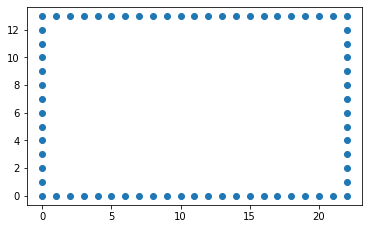

In [57]:
p4_pts_uv_np = np.array(p4_pts_uv)
plt.plot(p4_pts_uv_np[:,0], p4_pts_uv_np[:,1],'o')

plt.axis('scaled')

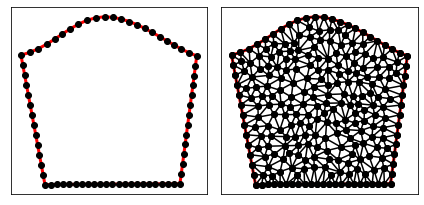

In [58]:
import triangle as tr
segments = []
for i in range(len(p4_pts)-1):
    segments.append([i, i+1])
segments.append([len(p4_pts)-1, 0])

A = dict(vertices=p4_pts, segments=segments)
B = tr.triangulate(A, 'pa.02')

tr.compare(plt, A, B)
plt.show()

In [59]:
import harmonic_mapping
p4_pts_uv_np = np.array(p4_pts_uv)
Us = harmonic_mapping.map(B['triangles'], B['vertices'], p4_pts_uv_np[:,0])
Vs = harmonic_mapping.map(B['triangles'], B['vertices'], p4_pts_uv_np[:,1])
UVs = np.stack((Us, Vs)).T

In [60]:
def writeOut(trngl_info, uvs, patch_id, offset):
    file = open("objs/patch_4.obj", "w")
    file.write("o patch_"+str(patch_id)+"\n")
    for i in range(len(trngl_info['vertices'])):
        v = trngl_info['vertices'][i]
        file.write("v " + str(v[0]) + " " + str(v[1]) + " 0.0\n")
    file.write("vn 0.0 0.0 1.0\n")
    for i in range(len(uvs)):
        uv = uvs[i]
        file.write("vt " + str(uv[0]) + " " + str(uv[1]) + "\n")
    for face in trngl_info['triangles']:
        file.write("f ")
        for i in range(3):
            file.write(str(face[i]+1+offset) + "/" + str(face[i]+1+offset) + "/1 ")
        file.write("\n")
    file.close()
writeOut(B, UVs, 4, 0)

(8.6270419375, 11.4854868125, -3.5898876843750003, -0.861372128125)

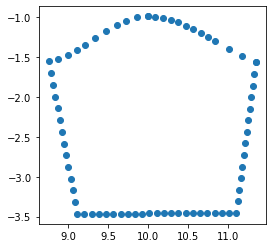

In [94]:
pts_np = np.array(p4_pts)

plt.plot(pts_np[:,0], pts_np[:,1], 'o')

plt.axis('scaled')

In [ ]:
p4_pts_uv_np

In [65]:
(getCurveLength(23) + getCurveLength(24))/2/0.13

13.064385313724273

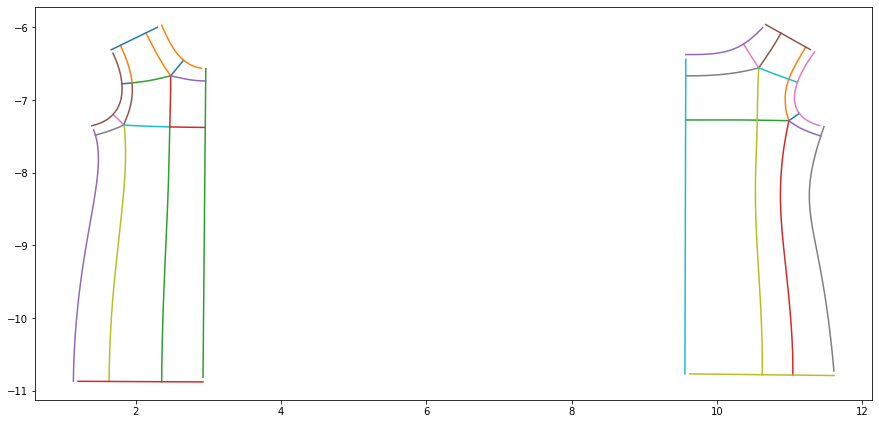

In [23]:
plt.figure(figsize=(15, 15))

for key in shape_sls:
    shape_sl = shape_sls[key]
    for sl in shape_sl:
        plt.plot(sl[:,0], sl[:,1])

for shape_id in [0, 5]:
    for cid in shape_curve_ids[shape_id]:
        plt.plot(bndry_verts[cid][:,0], bndry_verts[cid][:,1])
plt.axis('scaled')
plt.show()